In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
import zarr
from matplotlib import pyplot, colors, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [3]:
# Plot functions

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
    'lfd:filter': "#f28e2b",
})

my_colors = ["#4e79a7", "#e15759", "#59a14f", "#f28e2b"]



# Basic array functions

def sampling_lattice(res, pitch=1.0):
    """Return an array of shape (res,) containing the coordinates of a sampling lattice with a given pitch in "standard" order (with zero at the start)."""
    return scipy_fft.fftfreq(res).astype(np.float32) * (res * pitch)

def display_image(values, color_map=None, absolute=True, normalize=True, shift=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = np.abs(values) if absolute else values
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    values = scipy_fft.fftshift(values) if shift else values
    values = np.flip(values) if flip else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))



# Spatial and spectral transformations between the display and the eye spaces

def x_ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the position on the retina from the positions on the display layers."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b

def x_ab_to_p(x_a, x_b, z_a, z_b):
    """Return the position on the pupil from the positions on the display layers."""
    return z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b

def x_rp_to_a(x_r, x_p, z_r, z_a, z_f):
    """Return the position on the display layer A from the positions on the retina and pupil."""
    return (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p

def x_rp_to_b(x_r, x_p, z_r, z_b, z_f):
    """Return the position on the display layer B from the positions on the retina and pupil."""
    return (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p

def xi_ab_to_r(xi_a, xi_b, z_r, z_a, z_b):
    """Return the frequency on the retina from the frequencies on the display layers."""
    return (z_a/z_r) * xi_a + (z_b/z_r) * xi_b

def xi_ab_to_p(xi_a, xi_b, z_a, z_b, z_f):
    """Return the frequency on the pupil from the frequencies on the display layers."""
    return (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b

def xi_rp_to_a(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer A from the frequencies on the retina and pupil."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p

def xi_rp_to_b(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer B from the frequencies on the retina and pupil."""
    return (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p



# Interval functions

def intersect(*intervals):
    """Return the intersection of intervals of shape [2,...] where the first dimension is [lower, upper]."""
    result = intervals[0]
    for interval in intervals[1:]:
        result = np.clip(result, interval[0], interval[1])
    return result



# Indefinite integrals (antiderivatives) of kernels

def integral_DPP(x, x_p, w_p):
    c0 = 1 + x_p/w_p
    c1 = -1/w_p
    return x * c0 + np.square(x) * (c1/2)

def integral_DDPP(x, x_r, x_p, z_r, z_a, z_b, z_f, w_p, w_a, w_b):
    ca0 = (w_a - x_r * z_a/z_r)/w_a
    ca1 = (z_a/z_f - 1)/w_a
    cb0 = (w_b - x_r * z_b/z_r)/w_b
    cb1 = (z_b/z_f - 1)/w_b
    cp0 = 1 + x_p/w_p
    cp1 = -1/w_p
    c0 = ca0 * cb0 * cp0
    c1 = (ca1 * cb0 * cp0) + (ca0 * cb1 * cp0) + (ca0 * cb0 * cp1)
    c2 = (ca0 * cb1 * cp1) + (ca1 * cb0 * cp1) + (ca1 * cb1 * cp0)
    c3 =  ca1 * cb1 * cp1
    return x * c0 + np.square(x) * (c1/2) + np.power(x, 3) * (c2/3) + np.power(x, 4) * (c3/4)

In [4]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

pupil_diameter = 5.0

size_r = 5.5
size_a = size_r * z_a / abs(z_r) + 2*pupil_diameter
size_b = size_r * z_b / abs(z_r) + 2*pupil_diameter

res_r = 375
res_a = 5
res_b = 5

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

w_a = pitch_a
w_b = pitch_b
w_p = pupil_diameter

z_f = 100.0

Convolution:
$$ \begin{align*}
    (f * g)(x) = \int_{-\infty}^{\infty} f(t) \, g(x - t) \, \mathrm{d}t && (1.1)\\
\end{align*} $$

Therefore:
$$ \begin{align*}
    (f * g)(0) = \int_{-\infty}^{\infty} f(t) \, g^{\vee}\!(t) \, \mathrm{d}t && (1.2)\\
\end{align*} $$

Retina image:
$$ \begin{align*}
    E(x_r) = \int_{-\infty}^{\infty} L(x_r, x_p) \, P(x_p) \, \mathrm{d}x_p = (L * P^{\vee})(x_r, 0) = (L * P)(x_r, 0) && (1.3)\\
\end{align*} $$

Therefore we have:
$$ \begin{align*}
    f &= (L * P)(x_r, 0) && (1.4)\\
    \tilde{f} &= (\tilde{L} * P)(x_r, 0) = (\boldsymbol{c} * D * P)(x_r, 0) = (\boldsymbol{c} * \varphi)(x_r, 0) && (1.5)\\
    \varphi &= D * P && (1.6)\\
\end{align*} $$

Orthogonal projection:
$$ \begin{align*}
    (f - \tilde{f}) \bot V_{\varphi} \iff \langle f - \tilde{f}, \varphi(\cdot - k) \rangle = 0 && \forall \, k \in \mathbb{Z} \iff \pmb{[} (f - \tilde{f}) * \varphi^{\vee} \pmb{]} = 0 && (1.7)\\
\end{align*} $$

From there:
$$ \begin{align*}
    \pmb{[} f * \varphi^{\vee} \pmb{]} = \pmb{[} \tilde{f} * \varphi^{\vee} \pmb{]} \implies
    \pmb{[} (L * P)(x_r, 0) * \varphi^{\vee} \pmb{]} = \pmb{[} (\boldsymbol{c} * \varphi)(x_r, 0) * \varphi^{\vee} \pmb{]} \implies
    \boldsymbol{b} = A \boldsymbol{c} && (1.8)\\
\end{align*} $$

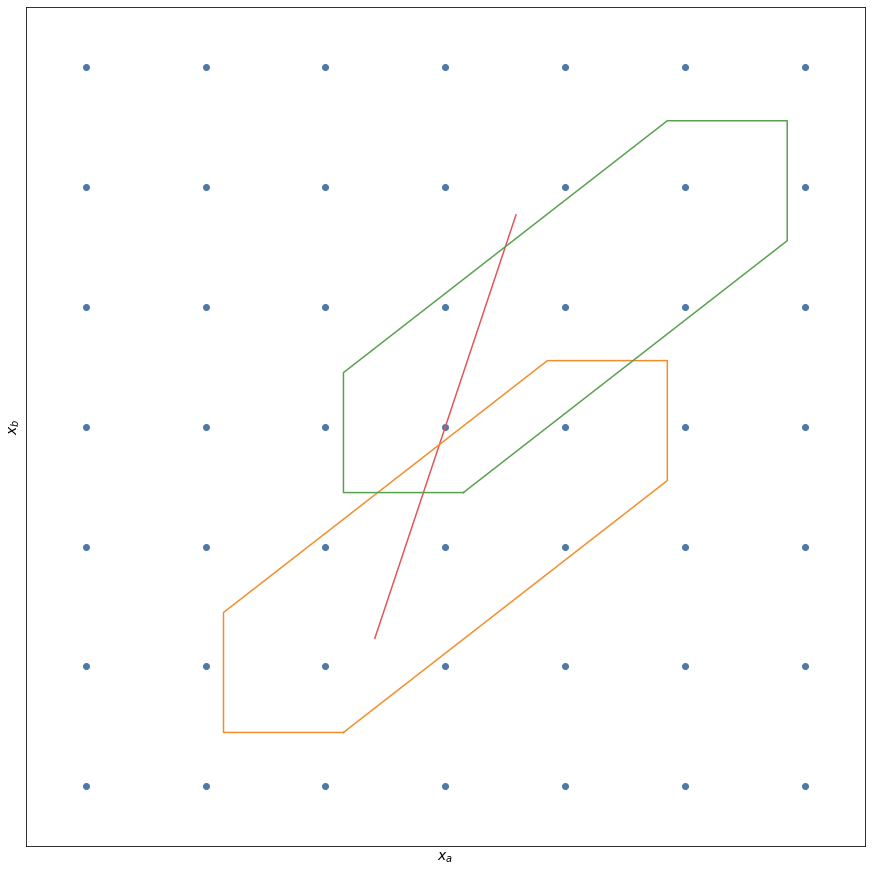

In [5]:
n = 7
l_r = [x_rp_to_a(1, 0, z_r, z_a, z_f), x_rp_to_b(1, 0, z_r, z_b, z_f)]
l_p = [x_rp_to_a(0, 1.5, z_r, z_a, z_f), x_rp_to_b(0, 1.5, z_r, z_b, z_f)]
phi = np.array([[0.5-l_p[0], -0.5-l_p[0], -0.5-l_p[0], -0.5+l_p[0], 0.5+l_p[0], 0.5+l_p[0], 0.5-l_p[0]], [-0.5-l_p[1], -0.5-l_p[1], 0.5-l_p[1], 0.5+l_p[1], 0.5+l_p[1], -0.5+l_p[1], -0.5-l_p[1]]])

c = sampling_lattice(n, 1)

fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

ax.set_xlabel(r'$x_a$', fontsize=14)
ax.set_ylabel(r'$x_b$', fontsize=14)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-n/2, n/2)
ax.set_ylim(-n/2, n/2)

ax.plot(l_r[0] * np.array([-1,1]), l_r[1] * np.array([-1,1]), color='lfd:retina')
ax.scatter(np.repeat(c, n), np.tile(c, n), color='lfd:signal')
ax.plot(phi[0], phi[1]-1, color='lfd:filter')
ax.plot(phi[0]+1, phi[1]+1, color='lfd:pupil')

pass

$$ \begin{align*}
    f_1(x) = \begin{cases}
        a_1 x + b_1 \quad \text{if} \quad l_1 < x < u_1 \\
        0 \quad \text{otherwise}
        \end{cases} && (2.1)\\
\end{align*} $$

$$ \begin{align*}
    f_1(x) \times f_2(x) = \begin{cases}
        (a_1 a_2) x^2 + (a_1 b_2 + b_1a_2) x + (b_1 b_2) \quad \text{if} \quad \text{clip}(l_1, [l_2, u_2]) < x < \text{clip}(u_1, [l_2, u_2]) \\
        0 \quad \text{otherwise}
        \end{cases} && (2.2)\\
\end{align*} $$

$$ \begin{align*}
    \int f_1(x) \times f_2(x) = \frac{a_1 a_2}{3} x^3 + \frac{a_1 b_2 + b_1 a_2}{2} x^2 + b_1 b_2 x \; \Bigg|_{\text{clip}(l_1, [l_2, u_2])}^{\text{clip}(u_1, [l_2, u_2])} && (2.3)\\
\end{align*} $$

---

Display space and eye space transformations:

$$ \begin{align*}
    \begin{bmatrix} x_r \\ x_p \end{bmatrix} =
    \begin{bmatrix}
        \frac{z_r(z_f - z_b)}{z_f(z_a - z_b)} & \frac{z_r(z_f - z_a)}{z_f(z_b - z_a)} \\
        \frac{z_b}{z_b - z_a} & \frac{z_a}{z_a - z_b} \\
    \end{bmatrix}
    \begin{bmatrix} x_a \\ x_b \end{bmatrix} && (3.1)\\
\end{align*} $$

$$ \begin{align*}
    \begin{bmatrix} x_a \\ x_b \end{bmatrix} =
    \begin{bmatrix}
        \frac{z_a}{z_r} & \frac{z_f - z_a}{z_f} \\
        \frac{z_b}{z_r} & \frac{z_f - z_b}{z_f} \\
    \end{bmatrix}
    \begin{bmatrix} x_r \\ x_p \end{bmatrix} && (3.2)\\
\end{align*} $$

From (3.1) we can find $l$ and $u$:

$$ \begin{align*}
    x_r = \frac{-z_r}{z_b - z_a} \left( \frac{z_f - z_b}{z_f} x_a - \frac{z_f - z_a}{z_f} x_b \right) && (3.3)\\
\end{align*} $$

From (3.2) we can find $p$ and $q$:

$$ \begin{align*}
    x_a = -\frac{z_a}{-z_r} x_r + \frac{z_f - z_a}{z_f} x_p \quad \therefore \quad
    x_r = \frac{-z_r}{z_a} \frac{z_f - z_a}{z_f} x_p - \frac{-z_r}{z_a} x_a && (3.4)\\
\end{align*} $$

And also the line equation:

$$ \begin{align*}
    x_a = -\frac{z_a}{-z_r} x_r + \frac{z_f - z_a}{z_f} x_p \quad \therefore \quad
    x_p = \frac{z_f}{z_f - z_a} \frac{z_a}{-z_r} x_r + \frac{z_f}{z_f - z_a} x_a && (3.5)\\
\end{align*} $$

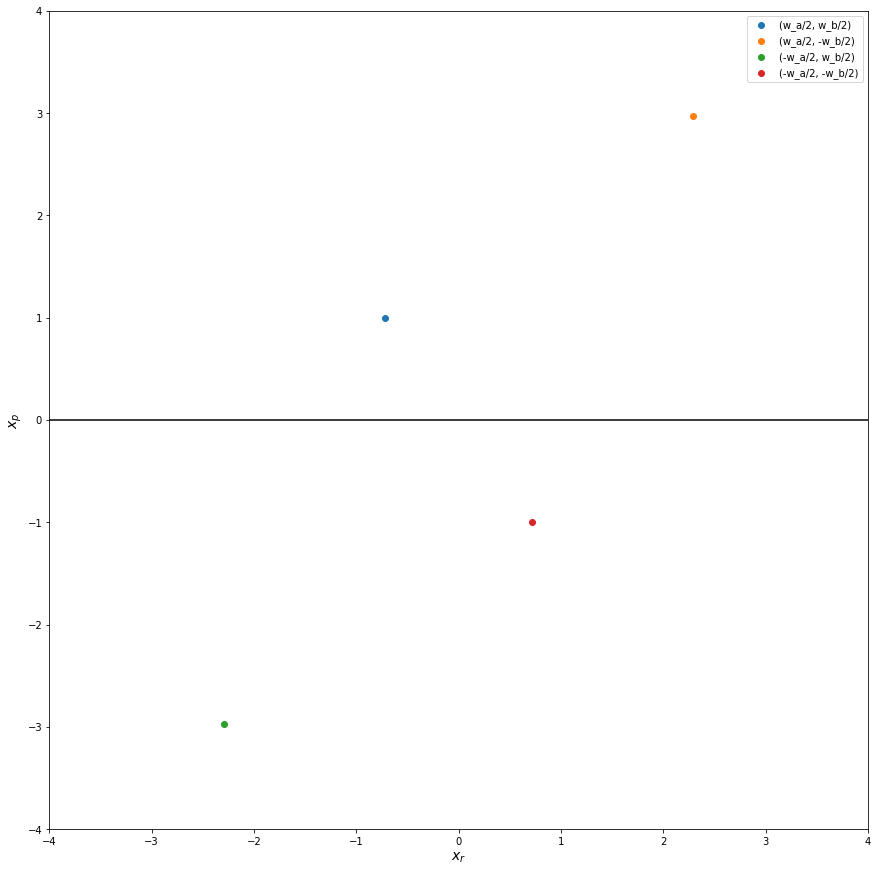

In [6]:
fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

ax.set_xlabel(r'$x_r$', fontsize=14)
ax.set_ylabel(r'$x_p$', fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

ax.scatter(x_ab_to_r(w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(w_a/2, w_b/2, z_a, z_b), label='(w_a/2, w_b/2)')
ax.scatter(x_ab_to_r(w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(w_a/2, -w_b/2, z_a, z_b), label='(w_a/2, -w_b/2)')
ax.scatter(x_ab_to_r(-w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(-w_a/2, w_b/2, z_a, z_b), label='(-w_a/2, w_b/2)')
ax.scatter(x_ab_to_r(-w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(-w_a/2, -w_b/2, z_a, z_b), label='(-w_a/2, -w_b/2)')

ax.legend()
pass

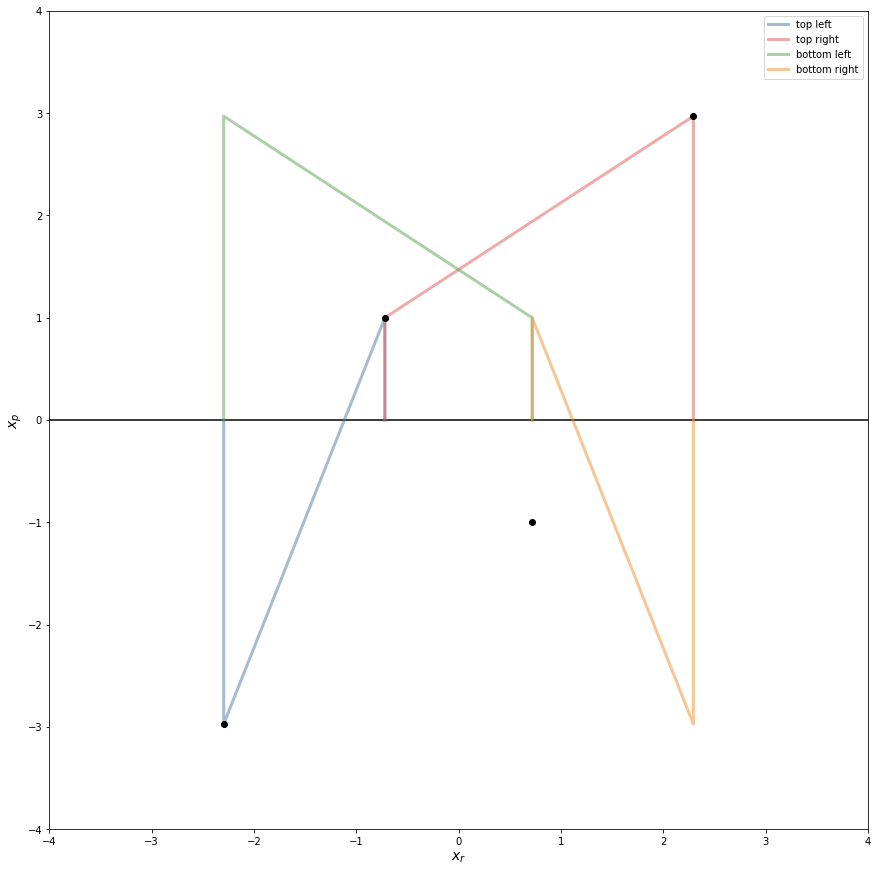

In [7]:
label = ['top left', 'top right', 'bottom left', 'bottom right']
l = [x_ab_to_r(-w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_r(w_a/2,  w_b/2, z_r, z_a, z_b, z_f), x_ab_to_r(-w_a/2,  w_b/2, z_r, z_a, z_b, z_f), x_ab_to_r(-w_a/2, -w_b/2, z_r, z_a, z_b, z_f)]
u = [x_ab_to_r( w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_r(w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_r(-w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_r( w_a/2, -w_b/2, z_r, z_a, z_b, z_f)]
a = [(-z_b/z_r) * z_f/(z_f - z_b), (-z_a/z_r) * z_f/(z_f - z_a), (z_a/z_r) * z_f/(z_f - z_a), (z_b/z_r) * z_f/(z_f - z_b)]
b = [z_f/(z_f - z_b) * (w_b/2), z_f/(z_f - z_a) * (w_a/2), z_f/(z_f - z_a) * (w_a/2), z_f/(z_f - z_b) * (w_b/2)]

fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

ax.set_xlabel(r'$x_r$', fontsize=14)
ax.set_ylabel(r'$x_p$', fontsize=14)
ax.set_aspect('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

ax.scatter(x_ab_to_r(w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(w_a/2, w_b/2, z_a, z_b), c='black', zorder=3)
ax.scatter(x_ab_to_r(w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(w_a/2, -w_b/2, z_a, z_b), c='black', zorder=3)
ax.scatter(x_ab_to_r(-w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(-w_a/2, w_b/2, z_a, z_b), c='black', zorder=3)
ax.scatter(x_ab_to_r(-w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(-w_a/2, -w_b/2, z_a, z_b), c='black', zorder=3)

for i in range(4):
    ax.plot([l[i], l[i], u[i], u[i]], [0.0, a[i] * l[i] + b[i], a[i] * u[i] + b[i], 0.0], label=label[i], color=my_colors[i], alpha=0.5, lw=3)

ax.legend()
pass

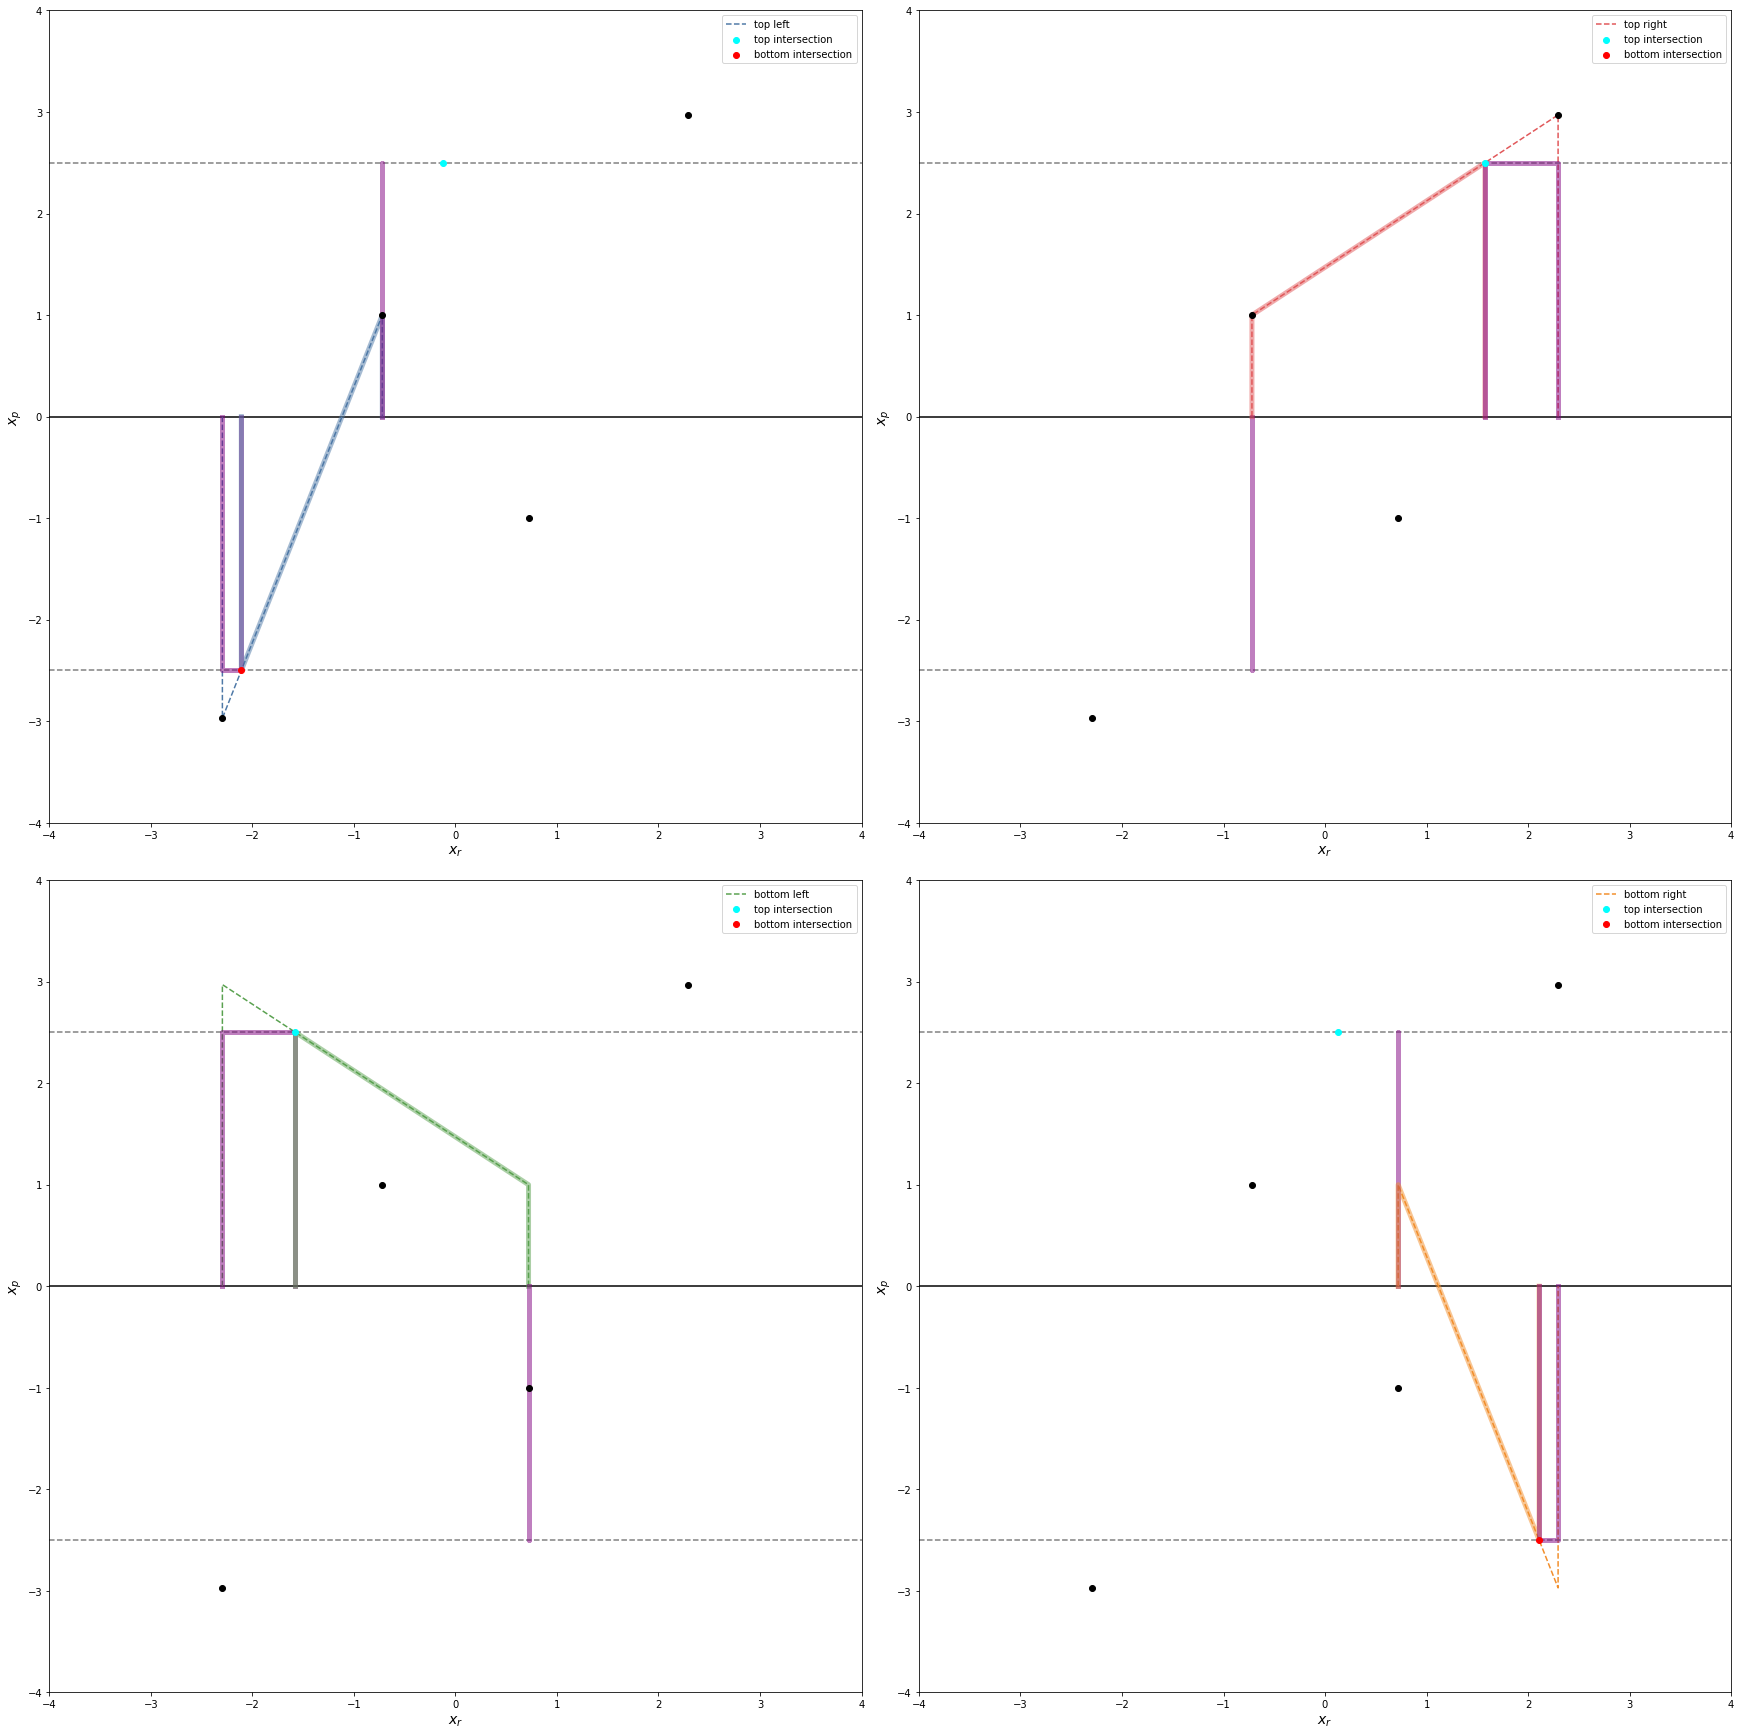

In [8]:
p = [-z_r * (z_f - z_b) / (z_b * z_f) * (pupil_diameter/2) + (z_r/z_b) * (w_b/2), -z_r * (z_f - z_a) / (z_a * z_f) * (pupil_diameter/2) + (z_r/z_a) * (w_a/2),
     z_r * (z_f - z_a) / (z_a * z_f) * (pupil_diameter/2) - (z_r/z_a) * (w_a/2), z_r * (z_f - z_b) / (z_b * z_f) * (pupil_diameter/2) - (z_r/z_b) * (w_b/2)]
q = [-z_r * (z_f - z_b) / (z_b * z_f) * (-pupil_diameter/2) + (z_r/z_b) * (w_b/2), -z_r * (z_f - z_a) / (z_a * z_f) * (-pupil_diameter/2) + (z_r/z_a) * (w_a/2),
     z_r * (z_f - z_a) / (z_a * z_f) * (-pupil_diameter/2) - (z_r/z_a) * (w_a/2), z_r * (z_f - z_b) / (z_b * z_f) * (-pupil_diameter/2) - (z_r/z_b) * (w_b/2)]

clipped_l = [l[0], np.clip(q[0], l[0], u[0]), np.clip(p[0], l[0], u[0]), l[1], np.clip(q[1], l[1], u[1]), np.clip(p[1], l[1], u[1]),
             l[2], np.clip(p[2], l[2], u[2]), np.clip(q[2], l[2], u[2]), l[3], np.clip(p[3], l[3], u[3]), np.clip(q[3], l[3], u[3])]
clipped_u = [np.clip(q[0], l[0], u[0]), np.clip(p[0], l[0], u[0]), u[0], np.clip(q[1], l[1], u[1]), np.clip(p[1], l[1], u[1]), u[1],
             np.clip(p[2], l[2], u[2]), np.clip(q[2], l[2], u[2]), u[2], np.clip(p[3], l[3], u[3]), np.clip(q[3], l[3], u[3]), u[3]]
clipped_a = [0.0, a[0], 0.0, 0.0, a[1], 0.0, 0.0, a[2], 0.0, 0.0, a[3], 0.0]
clipped_b = [-pupil_diameter/2, b[0], pupil_diameter/2, -pupil_diameter/2, b[1], pupil_diameter/2, pupil_diameter/2, b[2], -pupil_diameter/2, pupil_diameter/2, b[3], -pupil_diameter/2]

fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

for i in range(4):
    axs.flat[i].set_xlabel(r'$x_r$', fontsize=14)
    axs.flat[i].set_ylabel(r'$x_p$', fontsize=14)
    axs.flat[i].set_aspect('equal')
    axs.flat[i].set_xlim(-4, 4)
    axs.flat[i].set_ylim(-4, 4)

    axs.flat[i].axhline(y = 0.0, color = 'black', linestyle = '-')

    axs.flat[i].scatter(x_ab_to_r(w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(w_a/2, w_b/2, z_a, z_b), c='black', zorder=3)
    axs.flat[i].scatter(x_ab_to_r(w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(w_a/2, -w_b/2, z_a, z_b), c='black', zorder=3)
    axs.flat[i].scatter(x_ab_to_r(-w_a/2, w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(-w_a/2, w_b/2, z_a, z_b), c='black', zorder=3)
    axs.flat[i].scatter(x_ab_to_r(-w_a/2, -w_b/2, z_r, z_a, z_b, z_f), x_ab_to_p(-w_a/2, -w_b/2, z_a, z_b), c='black', zorder=3)

    axs.flat[i].plot([l[i], l[i], u[i], u[i]], [0.0, a[i] * l[i] + b[i], a[i] * u[i] + b[i], 0.0], label=label[i], color=my_colors[i], linestyle = '--')

    axs.flat[i].axhline(y = pupil_diameter/2, color = 'grey', linestyle = '--')
    axs.flat[i].axhline(y = -pupil_diameter/2, color = 'grey', linestyle = '--')

    axs.flat[i].scatter(p[i], a[i] * p[i] + b[i], c='cyan', label='top intersection', zorder=3)
    axs.flat[i].scatter(q[i], a[i] * q[i] + b[i], c='red', label='bottom intersection', zorder=3)

    axs.flat[i].plot([clipped_l[i*3], clipped_l[i*3], clipped_u[i*3], clipped_u[i*3]],
                     [0.0, clipped_a[i*3] * clipped_l[i*3] + clipped_b[i*3], clipped_a[i*3] * clipped_u[i*3] + clipped_b[i*3], 0.0],
                     color='purple', alpha=0.5, lw=5)
    axs.flat[i].plot([clipped_l[i*3+1], clipped_l[i*3+1], clipped_u[i*3+1], clipped_u[i*3+1]],
                     [0.0, clipped_a[i*3+1] * clipped_l[i*3+1] + clipped_b[i*3+1], clipped_a[i*3+1] * clipped_u[i*3+1] + clipped_b[i*3+1], 0.0],
                     color=my_colors[i], alpha=0.5, lw=5)
    axs.flat[i].plot([clipped_l[i*3+2], clipped_l[i*3+2], clipped_u[i*3+2], clipped_u[i*3+2]],
                     [0.0, clipped_a[i*3+2] * clipped_l[i*3+2] + clipped_b[i*3+2], clipped_a[i*3+2] * clipped_u[i*3+2] + clipped_b[i*3+2], 0.0],
                     color='purple', alpha=0.5, lw=5)

    axs.flat[i].legend()

In [9]:
x_a_at_ab = sampling_lattice(res_a, pitch_a)[:, np.newaxis]
x_b_at_ab = sampling_lattice(res_b, pitch_b)[np.newaxis, :]

x_r_at_ab = x_ab_to_r(x_a_at_ab, x_b_at_ab, z_r, z_a, z_b, z_f)
x_p_at_ab = x_ab_to_p(x_a_at_ab, x_b_at_ab, z_a, z_b)